In [3]:
import os
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

## ----- Imports -----
from utils import *
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F


DATETIME_STAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir_path = get_next_versioned_directory('rnn_training')
print(f"Created new directory: {new_dir_path}")

print(torch.__version__)
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_type = "mps"
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_type = "cuda"
    print("CUDA device found.")
else:
    print ("Using CPU.")
    device_type = "cpu"
    device = torch.device("cpu")

SEED = 42
set_seed(SEED)

# Usage: call once before training
log_file = setup_logging(new_dir_path)
logging.info(f'Seed: {SEED}')

NUM_EPOCHS = 30
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
NUM_LAYERS = 1  # Number of GRU layers
CROSS_VAL = True # if True, cross validate on the split condition
# pairs of (config, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]

# ==================== DATA FILTERING OPTIONS ====================
# Set to None to use all, or provide a list to filter

# Filter by configs (1-31). Set to None for all configs, or e.g., [1, 2, 3] for specific ones
FILTER_CONFIGS = None  # e.g., list(range(1, 11)) for configs 1-10, or [3, 7, 15]

# Filter by neurons/ROIs (1-indexed). Set to None for all neurons, or provide a list
# You can use good_pairs to extract neurons: [n for c, n in good_pairs]
# These neurons are used for initial conditions AND as the pool for targets
FILTER_NEURONS = None  # e.g., [21, 22, 23, 26, 27, 31] for specific neurons

# Target neurons to predict (1-indexed). Must be a subset of FILTER_NEURONS.
# Set to None to predict all FILTER_NEURONS, or provide a list for specific neurons
TARGET_NEURONS = set([pair[1] for pair in good_pairs])  # e.g., [31] to only predict neuron 31

# Filter by electrodes (0-9). Set to None for all electrodes
FILTER_ELECTRODES = None  # e.g., [0, 1, 2] for first 3 electrodes

# Filter by current levels (3, 4, 5). Set to None for all currents
FILTER_CURRENTS = None  # e.g., [5] for highest current only

# ================================================================

logging.info(f'Number of epochs {NUM_EPOCHS}')
logging.info(f'Cross validating {CROSS_VAL}')
logging.info(f'Target neurons for prediction {TARGET_NEURONS}')

checkpoint_filepath = os.path.join("rnn_training", DATETIME_STAMP, "best_model.pth")


data = scipy.io.loadmat('data.mat')
times = np.stack(data['times'][0, ...])
dfof = np.stack(data['dfof'][0, ...])
configs = np.stack( data['configs'][0, ...])
roi_used = data['roi_used']



# If filtering neurons, subset the dfof data to only include those neurons
if FILTER_NEURONS is not None:
    neuron_indices = [n - 1 for n in FILTER_NEURONS]  # Convert to 0-indexed
    dfof = np.array([session_dfof[:, neuron_indices] for session_dfof in dfof])
    logging.info(f"Filtered to {len(FILTER_NEURONS)} neurons: {FILTER_NEURONS}")
    logging.info(f"New dfof shape: {dfof.shape}")

# Validate and compute TARGET_NEURONS indices
# TARGET_NEURONS are the neurons to predict; must be subset of FILTER_NEURONS
if TARGET_NEURONS is None:
    # Default: predict all filtered neurons
    TARGET_NEURONS = FILTER_NEURONS if FILTER_NEURONS is not None else list(range(1, dfof[0].shape[1] + 1))
    target_indices = None  # Use all columns
else:
    # Validate that TARGET_NEURONS is a subset of FILTER_NEURONS (i.e. each target neuron should have an initial condition)
    if FILTER_NEURONS is not None:
        invalid_targets = set(TARGET_NEURONS) - set(FILTER_NEURONS)
        if invalid_targets:
            raise ValueError(f"TARGET_NEURONS {invalid_targets} not in FILTER_NEURONS {FILTER_NEURONS}")
        # Compute indices relative to filtered dfof
        target_indices = [FILTER_NEURONS.index(n) for n in TARGET_NEURONS]
    else:
        # No filtering, use original neuron indices (0-indexed)
        target_indices = [n - 1 for n in TARGET_NEURONS]
    logging.info(f"Target indices in filtered data: {target_indices}")

logging.info(f"configs shape: {configs.shape}")
logging.info(f"roi_used shape: {roi_used.shape}")
logging.info(f"times shape: {times.shape}")
logging.info(f"dfof shape: {dfof.shape}")

# Configs is a (n_sessions, n_rois, n_configs) array
# Times is a (n_sessions, n_trials, n_configs) array. They don't have to be serial (i.e. Channel X can be stimulated twice before Channel Y is stimulated once)
# Roi_used is a (512, 512) binary mask of which ROIs were used in the experiment
# dfof is a (n_sessions, n_timepoints, n_rois) array
# note that the sampling frequency of dfof is 30 Hz, so 30 frames is ~ 1 second of activity

Created new directory: rnn_training/20260115_170523
2.10.0.dev20251124
MPS available: True
tensor([1.], device='mps:0')
Random seed set as 42
2026-01-15 17:05:23,566 INFO: Logging started. Output file: rnn_training/20260115_170523/console.log
2026-01-15 17:05:23,566 INFO: Seed: 42
2026-01-15 17:05:23,567 INFO: Number of epochs 30
2026-01-15 17:05:23,567 INFO: Cross validating True
2026-01-15 17:05:23,569 INFO: Target neurons for prediction {21, 22, 23, 26, 27, 31}
2026-01-15 17:05:23,752 INFO: Target indices in filtered data: [20, 21, 22, 25, 26, 30]
2026-01-15 17:05:23,753 INFO: configs shape: (3, 110, 31)
2026-01-15 17:05:23,753 INFO: roi_used shape: (512, 512)
2026-01-15 17:05:23,754 INFO: times shape: (3, 8, 31)
2026-01-15 17:05:23,754 INFO: dfof shape: (3, 15600, 110)


In [4]:
from utils import make_trials_df
START_OFFSET = 0 
STIM_DELAY = 10  
trials_df = make_trials_df(times, start_offset=START_OFFSET, stim_delay=STIM_DELAY)
# Display summary
logging.info(f"DataFrame shape: {trials_df.shape}")
logging.info(f"Trials per session: {trials_df.groupby('session').size().to_dict()}")
logging.info(f"Unique values:")
logging.info(f"  Sessions: {', '.join(map(str, sorted(trials_df['session'].unique())))}")
logging.info(f"  Configs: {', '.join(map(str, sorted(trials_df['config'].unique())))}")
logging.info(f"  Electrodes: {', '.join(map(str, sorted(trials_df['electrode'].unique())))}")
logging.info(f"  Currents: {', '.join(map(str, sorted(trials_df['current'].unique())))}")

# Log filter status
logging.info(f"--- Filter Status ---")
logging.info(f"  FILTER_CONFIGS: {FILTER_CONFIGS if FILTER_CONFIGS else 'All'}")
logging.info(f"  FILTER_NEURONS: {FILTER_NEURONS if FILTER_NEURONS else 'All'}")
logging.info(f"  FILTER_ELECTRODES: {FILTER_ELECTRODES if FILTER_ELECTRODES else 'All'}")
logging.info(f"  FILTER_CURRENTS: {FILTER_CURRENTS if FILTER_CURRENTS else 'All'}")

logging.info(f"trials_df head:\n{trials_df.head(10)}")
logging.info(f"--- Example queries ---")
logging.info(f"Electrode 9, Current 5: {len(trials_df[(trials_df['electrode'] == 9) & (trials_df['current'] == 5)])} trials")
logging.info(f"Session 0, Config 7: {len(trials_df[(trials_df['session'] == 0) & (trials_df['config'] == 7)])} trials")

2026-01-15 17:05:28,908 INFO: Creating trials DataFrame with START_OFFSET=0 (snippet starts 0 frames before trial_start_time)
2026-01-15 17:05:28,909 INFO: Creating trials DataFrame with STIM_DELAY=10 (stim occurs 10 frames after trial_start_time)
2026-01-15 17:05:28,913 INFO: DataFrame shape: (744, 9)
2026-01-15 17:05:28,915 INFO: Trials per session: {0: 248, 1: 248, 2: 248}
2026-01-15 17:05:28,915 INFO: Unique values:
2026-01-15 17:05:28,916 INFO:   Sessions: 0, 1, 2
2026-01-15 17:05:28,916 INFO:   Configs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30
2026-01-15 17:05:28,918 INFO:   Electrodes: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
2026-01-15 17:05:28,918 INFO:   Currents: 0, 3, 4, 5
2026-01-15 17:05:28,919 INFO: --- Filter Status ---
2026-01-15 17:05:28,919 INFO:   FILTER_CONFIGS: All
2026-01-15 17:05:28,919 INFO:   FILTER_NEURONS: All
2026-01-15 17:05:28,920 INFO:   FILTER_ELECTRODES: All
2026-01-15 17

This data contains single-electrode stims @ 3 current levels over 10 possible electrodes = 30 combinations + no-stim =  31 configurations total,Each configuration repeated 8 times in each of the
3 sessions. 2P imaging occurs at 30Hz per neuron.

In [ ]:
# ----- Create snippets DataFrame and split data -----
from utils import make_snippets_df, snippets_df_to_arrays
from sklearn.model_selection import train_test_split

# Create snippets DataFrame from trials_df
# Stimulation timing is derived from trials_df['stim_time'] = trial_start_time + STIM_DELAY
# overlap=True creates overlapping snippets (like original make_snippets), giving ~46k+ snippets
# overlap=False only creates snippets aligned to trial stim times (~744 snippets)
# stride controls step size for overlapping snippets (1=full overlap, length=non-overlapping)
SNIPPET_STRIDE = 1  # Set to SNIPPET_LENGTH for non-overlapping, only if SNIPPET_OVERLAP is True (otherwise ignored)

snippets_df = make_snippets_df(trials_df, dfof, SNIPPET_LENGTH, 
                                overlap=SNIPPET_OVERLAP, stride=SNIPPET_STRIDE)

logging.info(f"Snippets DataFrame shape: {snippets_df.shape}")
logging.info(f"Valid snippets: {snippets_df['valid'].sum()}")
logging.info(f"Snippets with stim at t=0: {snippets_df['stim_at_t0'].sum()}")

# ==================== SPLIT STRATEGY ===================
# Choose one of: 'random', 'session', 'trial', 'config', 'electrode', 'current', 'stim_at_t0'
SPLIT_STRATEGY = 'trial'

# For 'session': which sessions to hold out for test (only valid if SPLIT_STRATEGY=='session')
HOLDOUT_SESSIONS = [0]  # e.g., session 2 as test (range 0-2 inclusive)

# For 'trial': which trial indices to hold out (only valid if SPLIT_STRATEGY=='trial')
HOLDOUT_TRIALS = []  # e.g., trials 1 and 7 as test (0-indexed, range 0-7 inclusive)

# For 'config': which configs to hold out (only valid if SPLIT_STRATEGY=='config')
HOLDOUT_CONFIGS = []  # e.g., configs 28-30 as test; range is 1-31 (inclusive)

# For 'electrode': which electrodes to hold out (only valid if SPLIT_STRATEGY=='electrode')
HOLDOUT_ELECTRODES = []  # e.g., electrode 9 as test (range 0-9 inclusive and None, which would select config 31))

# For 'current': which current levels to hold out (only valid if SPLIT_STRATEGY=='current')
HOLDOUT_CURRENTS = []  # e.g., highest current as test (either 0, 3, 4, or 5)

# ========================================================
VAL_SIZE = 0.15
valid_df = snippets_df[snippets_df['valid']].copy()
print (valid_df.columns)
# Random split proportions if using random SPLIT_STRATEGY
# Get sessions
sessions = sorted(valid_df['session'].unique())
train_df, val_df, test_df = create_split_dfs(
    split_strategy=SPLIT_STRATEGY,
    valid_df=valid_df,
    trials_df=trials_df,
    sessions=sessions,
    snippet_length=SNIPPET_LENGTH,
    val_size=VAL_SIZE,
    seed=SEED,
    holdout_sessions=HOLDOUT_SESSIONS,
    holdout_trials=HOLDOUT_TRIALS,
    holdout_configs=HOLDOUT_CONFIGS,
    holdout_electrodes=HOLDOUT_ELECTRODES,
    holdout_currents=HOLDOUT_CURRENTS,
 )

for dataframe, flag in ((train_df, False), (val_df, False), (test_df, True)):
    dataframe['is_test'] = flag

valid_df['is_test'] = valid_df.index.isin(test_df.index)
valid_df.sort_values(by=['first_config', 'session', 'first_trial'], inplace=True)
print ("Electrodes: ", valid_df["first_electrode"].unique())
print ("Currents: ", valid_df["first_current"].unique())
print ("Configs: ", valid_df['first_config'].unique())

2026-01-15 17:05:40,917 INFO: Snippets DataFrame shape: (744, 18)
2026-01-15 17:05:40,917 INFO: Valid snippets: 744
2026-01-15 17:05:40,918 INFO: Snippets with stim at t=0: 0
Index(['session', 'snippet_start', 'first_config', 'first_electrode',
       'first_current', 'first_trial', 'first_stim_time', 'all_configs',
       'all_electrodes', 'all_currents', 'all_trials', 'has_stim',
       'stim_at_t0', 'num_stims', 'initial_condition', 'activity_snippet',
       'stim_snippet', 'valid'],
      dtype='object')
2026-01-15 17:05:40,929 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-15 17:05:40,930 INFO: === Split Summary (session) ===
2026-01-15 17:05:40,931 INFO: Train: 421 samples (56.6%)
2026-01-15 17:05:40,931 INFO:   Sessions: [np.int64(1), np.int64(2)]
2026-01-15 17:05:40,932 INFO: Val: 75 samples (10.1%)
2026-01-15 17:05:40,933 INFO: Test: 248 samples (33.3%)
2026-01-15 17:05:40,934 INFO:   Sessions: [np.int64(0)]
Electrodes:  [ 0.  1.  2.  3.  4.  5.  6

/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipykernel_92180/2004936600.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['is_test'] = flag


In [7]:
from utils import debug_stim_alignment
debug_stim_alignment(START_OFFSET, STIM_DELAY, SNIPPET_LENGTH, SNIPPET_OVERLAP, trials_df, train_df)


=== DEBUG: Checking stim alignment ===
START_OFFSET = 0
STIM_DELAY = 10
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
session                  0
trial                    0
config                   1
electrode              0.0
current                  3
trial_start_time      2811
stim_time           2821.0
start_time            2811
is_stim               True
Name: 0, dtype: object

First trial: session=0, config=1
  trial_start_time = 2811
  stim_time = 2821.0 (should be trial_start_time + STIM_DELAY)
  start_time = 2811 (snippet starts here)
  Expected stim at snippet frame: 10.0

--- First train snippet from _df ---
session                                                              2
snippet_start                                                     4990
first_config                                                        20
first_electrode                                                    6.0
first_current                                                        4
first_trial          


=== Trial vs Snippet Alignment Summary ===
STIM_DELAY = 10 (frames after trial start when stim occurs)
START_OFFSET = 0 (snippet starts this many frames before stim)

Expected: stim_time = start_time + STIM_DELAY
Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)

In snippets with stim_at_t0=True, first_stim_time should be ~0

Test snippets: 248, unique trials in test: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]


/Users/shubhom/Downloads/stim_project_from_NS/viz.py:501: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_trials = trials_df.groupby('session').apply(lambda x: x.sample(min(3, len(x)), random_state=seed)).reset_index(drop=True)


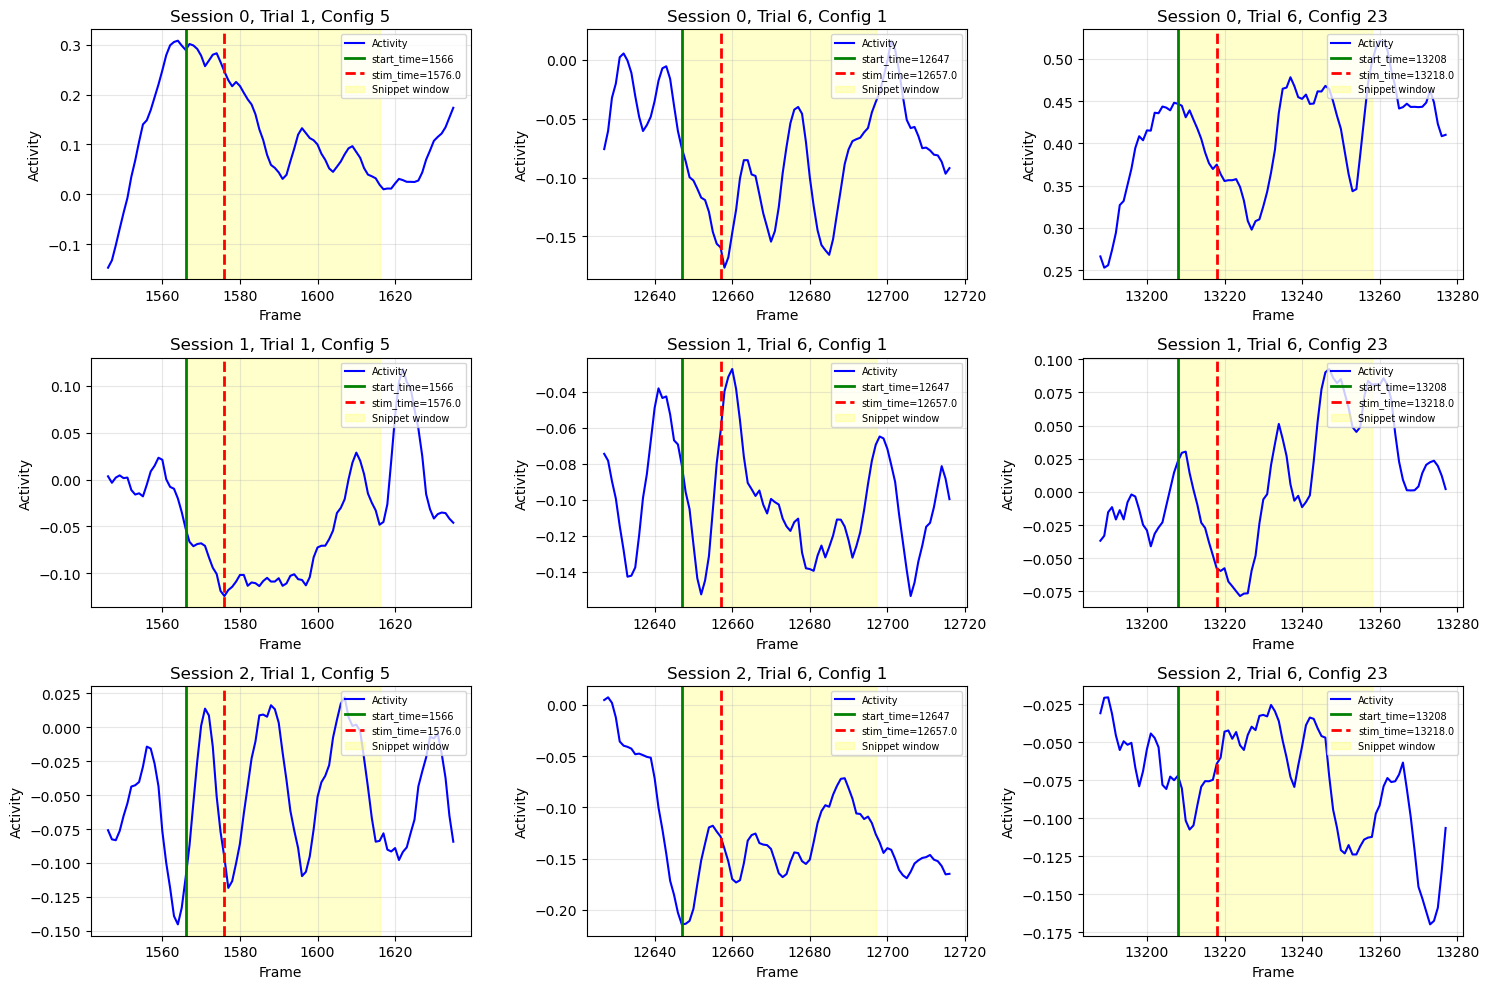

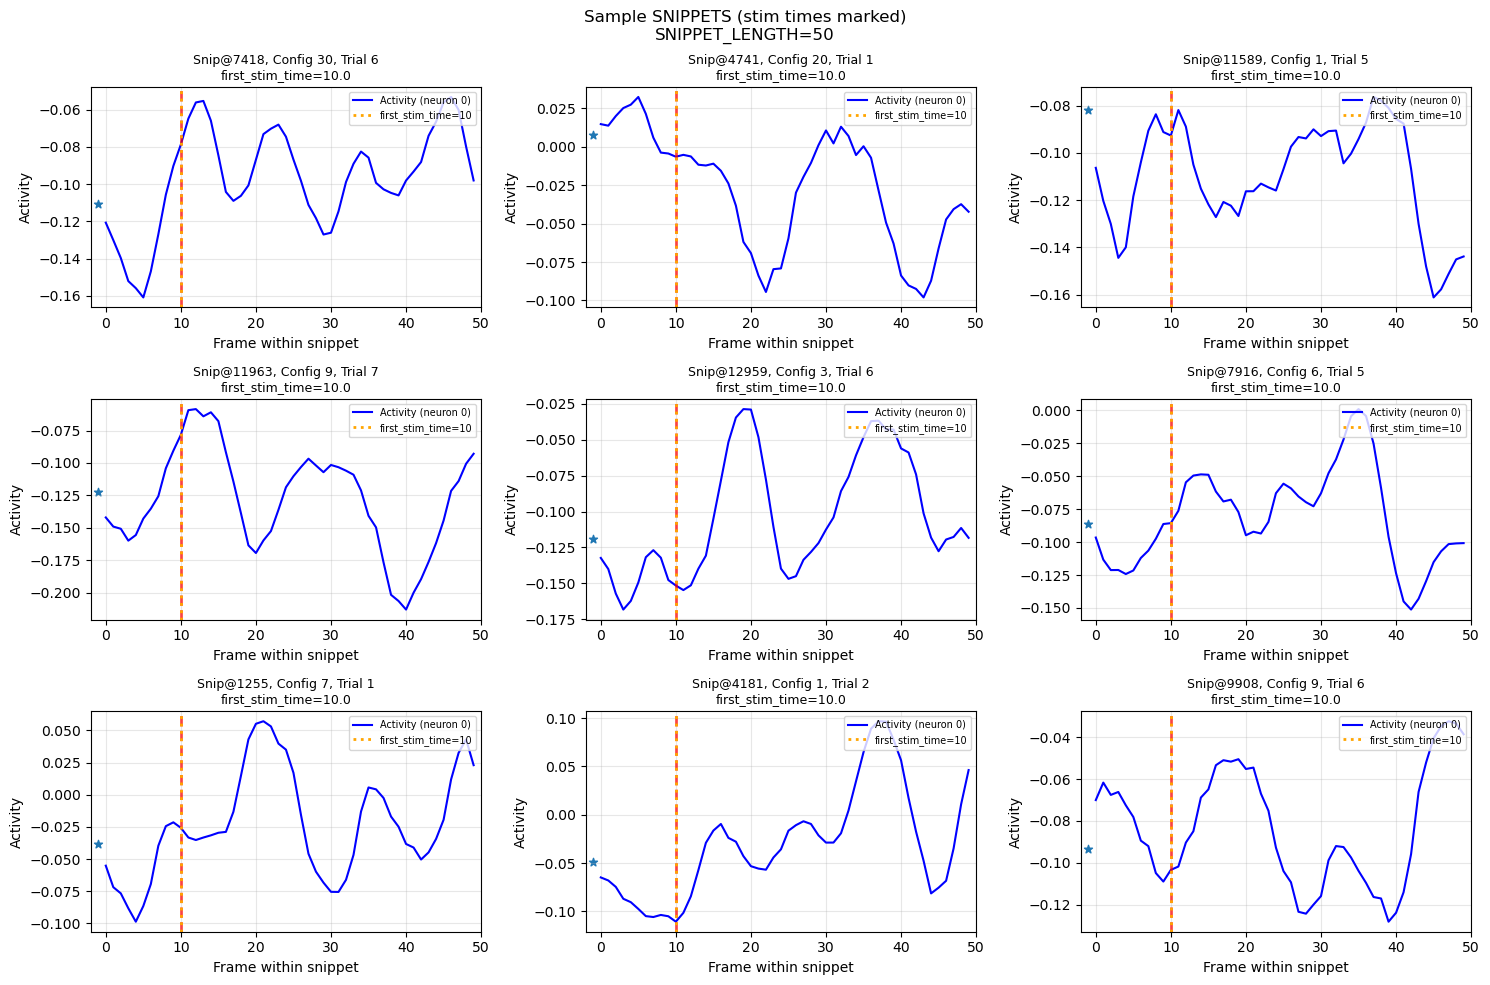

In [8]:
from viz import show_trials_snippets_sample

# Print summary for debugging
print("\n=== Trial vs Snippet Alignment Summary ===")
print(f"STIM_DELAY = {STIM_DELAY} (frames after trial start when stim occurs)")
print(f"START_OFFSET = {START_OFFSET} (snippet starts this many frames before stim)")
print(f"\nExpected: stim_time = start_time + STIM_DELAY")
print(f"Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)")
print(f"\nIn snippets with stim_at_t0=True, first_stim_time should be ~0")
print(f"\nTest snippets: {len(test_df)}, unique trials in test: {sorted(test_df['first_trial'].dropna().unique())}")
show_trials_snippets_sample(trials_df, train_df, dfof, SNIPPET_LENGTH, seed=SEED, savepath=new_dir_path)

In [9]:
# Pass target_indices to SeqDataset to select which neurons to predict
# Initial conditions use all FILTER_NEURONS, predictions use only TARGET_NEURONS
train_ds = SeqDataset(df=train_df, target_indices=target_indices)
val_ds = SeqDataset(df=val_df, target_indices=target_indices)
test_ds = SeqDataset(df=test_df, target_indices=target_indices)



# --- prepare datasets using DataFrame-based SeqDataset ---
batch_size = 4
logging.info(f'Batch size: {batch_size}')


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 1, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

logging.info("Dataset sizes -> train: %d, val: %d, test: %d",
             len(train_ds), len(val_ds), len(test_ds))
logging.info(f"Target neurons: {TARGET_NEURONS} (indices: {target_indices})")


# --- model, loss, optimizer ---
# Get dimensions from the dataset
sample_stim, _ = train_ds[0]
input_size = sample_stim[0].shape[1]  # n_electrodes
# Note: initial_conds uses all FILTER_NEURONS, but output_size matches TARGET_NEURONS
output_size = train_ds.Y.shape[2]     # n_target_neurons
initial_cond_size = train_ds.initial_conds.shape[1]  # n_filter_neurons

N_UNITS = 32  # hidden state size
LOSS_TYPE = "mse"  # Options: 'mse', 'mae', 'weighted_mae'
LR = 0.001
REGULARIZE = 0

# Create model: initial_cond_size uses all FILTER_NEURONS, output_size uses TARGET_NEURONS
model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size).to(device)
logging.info(f'Model architecture:\n{model}')
logging.info(f'Train input size: {input_size}')
logging.info(f'Initial condition size: {initial_cond_size} (FILTER_NEURONS)')
logging.info(f'Train output size: {output_size} (TARGET_NEURONS)')
logging.info(f'Hidden state size: {N_UNITS}')
logging.info(f'Number of GRU layers: {NUM_LAYERS}')


if LOSS_TYPE == 'mae':
    criterion = nn.MSELoss()
elif LOSS_TYPE == 'mae':
    criterion = nn.L1Loss()
elif LOSS_TYPE == 'weighted_mae':
    from modules import WeightedMAELoss
    # Weighted loss parameters
    STIM_WEIGHT = 5.0   # How much more to weight stim-adjacent frames
    STIM_WINDOW = 15    # Frames after stim to upweight (~0.5 sec at 30Hz)
    WEIGHT_DECAY = 'none'  # 'none', 'linear', or 'exp'
    criterion = WeightedMAELoss(stim_weight=STIM_WEIGHT, window=STIM_WINDOW, decay=WEIGHT_DECAY)
    logging.info(f'Using WeightedMAELoss: stim_weight={STIM_WEIGHT}, window={STIM_WINDOW}, decay={WEIGHT_DECAY}')
else:
    criterion = nn.MSELoss()

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=REGULARIZE)
logging.info(f"Learning rate {LR}")
logging.info(f"Optimizer: {OPTIMIZER}")
logging.info(f"Loss type: {LOSS_TYPE}")
logging.info(f"Regularization coefficient: {REGULARIZE}")

# print (f'Example input: {example_input[0]}, \n\nactivity_initial: {example_input[1]}')


2026-01-15 17:05:46,691 INFO: Batch size: 4
2026-01-15 17:05:46,692 INFO: Dataset sizes -> train: 421, val: 75, test: 248
2026-01-15 17:05:46,692 INFO: Target neurons: {21, 22, 23, 26, 27, 31} (indices: [20, 21, 22, 25, 26, 30])
2026-01-15 17:05:46,696 INFO: Model architecture:
RNNModel(
  (initial_state_projection): Linear(in_features=110, out_features=32, bias=True)
  (rnn): GRU(10, 32, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=6, bias=True)
  )
)
2026-01-15 17:05:46,696 INFO: Train input size: 10
2026-01-15 17:05:46,697 INFO: Initial condition size: 110 (FILTER_NEURONS)
2026-01-15 17:05:46,698 INFO: Train output size: 6 (TARGET_NEURONS)
2026-01-15 17:05:46,698 INFO: Hidden state size: 32
2026-01-15 17:05:46,699 INFO: Number of GRU layers: 1
2026-01-15 17:05:47,317 INFO: Learning rate 0.001
2026-01-15 17:05:47,318 INFO: Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_

## Visualize train/val/test split across sessions as timelines
###  Goal: verify that test snippets don't temporally overlap with train snippets

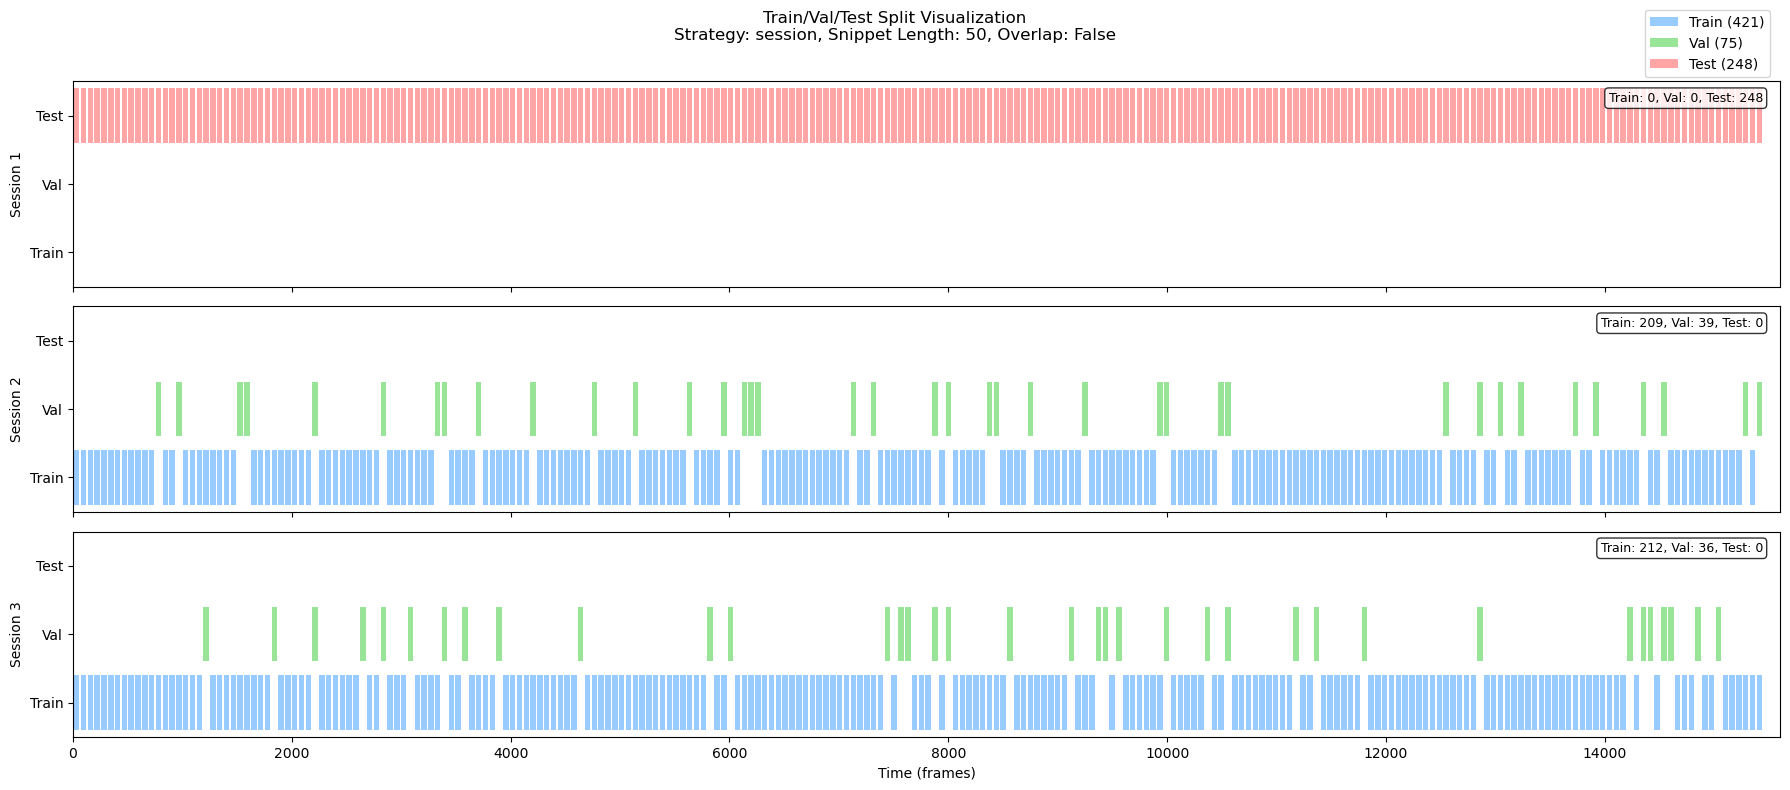


=== Overlap Analysis ===
Session 0: Train frames: 0, Test frames: 12400, Overlap: 0 frames (0.0% of test)
Session 1: Train frames: 10450, Test frames: 0, Overlap: 0 frames (0.0% of test)
Session 2: Train frames: 10600, Test frames: 0, Overlap: 0 frames (0.0% of test)
Visualization saved to: rnn_training/20260115_170523/split_visualization.png


In [10]:
from viz import plot_split_visualization
    
# Call the visualization helper
plot_split_visualization(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    dfof=dfof,
    snippet_length=SNIPPET_LENGTH,
    split_strategy=SPLIT_STRATEGY,
    snippet_overlap=SNIPPET_OVERLAP,
    holdout_trials=HOLDOUT_TRIALS if 'HOLDOUT_TRIALS' in globals() else [],
    trials_df=trials_df,
    output_dir=new_dir_path,
    num_sessions=3,
    figure_size=(18, 8),
    bar_height=0.8,
    dpi=150,
 )

In [11]:
from tqdm.notebook import tqdm
import time
import torch
import logging

def train_with_progress(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    checkpoint_path,
    device,
    device_type,   # e.g. "cuda", "mps", "cpu"
    num_epochs,
    loss_type=None,
    use_amp=True,
    max_grad_norm=1.0,
    early_stop_patience=5,
    min_epochs_before_early_stop=5,
):
    """
    Training loop with:
      - tqdm epoch + batch progress
      - AMP (autocast + GradScaler) when supported
      - optional weighted loss: criterion(outputs, targets, inputs)
      - validation + best-checkpoint save
      - simple early stopping on 'patience' consecutive non-improvements
    """
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}

    # AMP support varies by device; GradScaler is meaningful on CUDA.
    amp_enabled = bool(use_amp) and (device_type in ("cuda",))
    scaler = torch.amp.GradScaler(enabled=amp_enabled)

    def compute_loss(outputs, targets, inputs):
        if loss_type == "weighted_mae":
            return criterion(outputs, targets, inputs)
        return criterion(outputs, targets)

    epoch_pbar = tqdm(range(1, num_epochs + 1), desc="Epochs", unit="ep")

    for epoch in epoch_pbar:
        t0 = time.perf_counter()

        # -------------------- train --------------------
        model.train()
        running_loss = 0.0
        n_train = 0

        for (inputs, activity_initial), targets in tqdm(
            train_loader, desc=f"Epoch {epoch} Train", leave=False, unit="batch"
        ):
            inputs = inputs.to(device, non_blocking=True)
            activity_initial = activity_initial.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                outputs = model((inputs, activity_initial))
                loss = compute_loss(outputs, targets, inputs)

            if amp_enabled:
                scaler.scale(loss).backward()
                # unscale before clipping so clip is in true scale
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                optimizer.step()

            bs = inputs.size(0)
            running_loss += loss.item() * bs
            n_train += bs

        train_loss = running_loss / max(n_train, 1)
        history["train_loss"].append(train_loss)
        logging.info(f"Epoch {epoch} Train loss: {train_loss:.6f}")

        # -------------------- val --------------------
        model.eval()
        val_running = 0.0
        n_val = 0

        with torch.no_grad():
            for (inputs, activity_initial), targets in tqdm(
                val_loader, desc=f"Epoch {epoch} Val", leave=False, unit="batch"
            ):
                inputs = inputs.to(device, non_blocking=True)
                activity_initial = activity_initial.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                    outputs = model((inputs, activity_initial))
                    vloss = compute_loss(outputs, targets, inputs)

                bs = inputs.size(0)
                val_running += vloss.item() * bs
                n_val += bs

        val_loss = val_running / max(n_val, 1)
        history["val_loss"].append(val_loss)
        logging.info(f"Epoch {epoch} Validation loss: {val_loss:.6f}")

        # checkpoint best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            logging.info(f"Saved best model (val={best_val_loss:.6f}) -> {checkpoint_path}")

        # early stopping: no improvement for `patience` consecutive epochs
        if epoch > min_epochs_before_early_stop and len(history["val_loss"]) >= (early_stop_patience + 1):
            recent = history["val_loss"][-(early_stop_patience + 1):]
            no_improve = all(recent[i] >= recent[i - 1] for i in range(1, len(recent)))
            if no_improve:
                logging.info(
                    f"Early stopping: val loss did not improve for {early_stop_patience} consecutive epochs."
                )
                epoch_time = time.perf_counter() - t0
                epoch_pbar.set_postfix(
                    {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
                )
                break

        epoch_time = time.perf_counter() - t0
        epoch_pbar.set_postfix(
            {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
        )

    return history, best_val_loss

use_amp = True

# history, best_val_loss = train_with_progress(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=OPTIMIZER,  
#     checkpoint_path=checkpoint_filepath,
#     device=device,
#     device_type=device_type,   # "cuda" / "mps" / "cpu"
#     num_epochs=NUM_EPOCHS,
#     loss_type=LOSS_TYPE,
#     use_amp=use_amp,
# )


## Calculate test-error

In [12]:
import os
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import logging
import json

from utils import get_inputs_outputs_targets, get_model_error, create_split_dfs
from modules import RNNModel, SeqDataset

# ----- Hyperparameters (collected in dict for reproducibility) -----
CV_HPARAMS = {
    'split_strategy': SPLIT_STRATEGY,
    'snippet_length': SNIPPET_LENGTH,
    'snippet_overlap': SNIPPET_OVERLAP,
    'snippet_stride': SNIPPET_STRIDE,
    'val_size': VAL_SIZE,
    'seed': SEED,
    'batch_size': batch_size,
    'n_units': N_UNITS,
    'num_layers': NUM_LAYERS,
    'loss_type': LOSS_TYPE,
    'lr': LR,
    'regularize': REGULARIZE,
    'num_epochs': NUM_EPOCHS,
    'early_stop_patience': 5,
    'use_amp': use_amp,
}

logging.info(f"=== Cross-Validation Hyperparameters ===")
for k, v in CV_HPARAMS.items():
    logging.info(f"  {k}: {v}")

# ----- Determine fold elements based on split strategy -----
if CV_HPARAMS['split_strategy'] == 'trial':
    fold_elements = list(range(8))  # trials 0-7
    holdout_key = 'holdout_trials'
elif CV_HPARAMS['split_strategy'] == 'session':
    fold_elements = list(range(3))  # sessions 0-2
    holdout_key = 'holdout_sessions'
elif CV_HPARAMS['split_strategy'] == 'config':
    fold_elements = list(range(1, 32))  # configs 1-31
    holdout_key = 'holdout_configs'
elif CV_HPARAMS['split_strategy'] == 'electrode':
    fold_elements = list(range(10)) + [None]  # electrodes 0-9 + None (config 31)
    holdout_key = 'holdout_electrodes'
elif CV_HPARAMS['split_strategy'] == 'current':
    fold_elements = [0, 3, 4, 5]  # current levels (0 = no stim)
    holdout_key = 'holdout_currents'
else:
    raise ValueError(f"Cross-validation not supported for strategy: {CV_HPARAMS['split_strategy']}")

n_folds = len(fold_elements)
logging.info(f"Running {n_folds}-fold CV on '{CV_HPARAMS['split_strategy']}' with elements: {fold_elements}")

# ----- Cross-validation loop -----
cv_results = []
for fold_idx, holdout_element in enumerate(tqdm(fold_elements, desc="CV Folds")):
    logging.info(f"\n{'='*60}")
    logging.info(f"FOLD {fold_idx + 1}/{n_folds}: Holding out {CV_HPARAMS['split_strategy']}={holdout_element}")
    logging.info(f"{'='*60}")
    
    # Build holdout kwargs: only set the relevant holdout, others empty
    holdout_kwargs = {
        'holdout_sessions': [],
        'holdout_trials': [],
        'holdout_configs': [],
        'holdout_electrodes': [],
        'holdout_currents': [],
    }
    holdout_kwargs[holdout_key] = [holdout_element]
    
    # Create train/val/test splits for this fold
    fold_train_df, fold_val_df, fold_test_df = create_split_dfs(
        split_strategy=CV_HPARAMS['split_strategy'],
        valid_df=valid_df.copy(),
        trials_df=trials_df,
        sessions=sessions,
        snippet_length=CV_HPARAMS['snippet_length'],
        val_size=CV_HPARAMS['val_size'],
        seed=CV_HPARAMS['seed'],
        **holdout_kwargs
    )
    
    # Skip fold if test set is empty
    if len(fold_test_df) == 0:
        logging.warning(f"Fold {fold_idx + 1}: Empty test set for holdout={holdout_element}, skipping.")
        continue
    
    logging.info(f"Fold {fold_idx + 1} sizes: train={len(fold_train_df)}, val={len(fold_val_df)}, test={len(fold_test_df)}")
    
    # Create datasets and loaders
    fold_train_ds = SeqDataset(df=fold_train_df, target_indices=target_indices)
    fold_val_ds = SeqDataset(df=fold_val_df, target_indices=target_indices)
    fold_test_ds = SeqDataset(df=fold_test_df, target_indices=target_indices)
    
    fold_train_loader = DataLoader(fold_train_ds, batch_size=CV_HPARAMS['batch_size'], 
                                   shuffle=True, num_workers=max(1, os.cpu_count() - 1), pin_memory=True)
    fold_val_loader = DataLoader(fold_val_ds, batch_size=CV_HPARAMS['batch_size'], 
                                 shuffle=False, pin_memory=True)
    fold_test_loader = DataLoader(fold_test_ds, batch_size=CV_HPARAMS['batch_size'], 
                                  shuffle=False, pin_memory=True)
    
    # Initialize fresh model for this fold
    fold_model = RNNModel(
        input_size=input_size, 
        units=CV_HPARAMS['n_units'], 
        output_size=output_size,
        num_layers=CV_HPARAMS['num_layers'], 
        initial_cond_size=initial_cond_size
    ).to(device)
    
    # Loss and optimizer
    if CV_HPARAMS['loss_type'] == 'mae':
        fold_criterion = nn.L1Loss()
    elif CV_HPARAMS['loss_type'] == 'weighted_mae':
        from modules import WeightedMAELoss
        fold_criterion = WeightedMAELoss(stim_weight=5.0, window=15, decay='none')
    else:
        fold_criterion = nn.MSELoss()
    
    fold_optimizer = torch.optim.Adam(fold_model.parameters(), lr=CV_HPARAMS['lr'], 
                                       weight_decay=CV_HPARAMS['regularize'])
    
    # Checkpoint path for this fold
    fold_checkpoint = os.path.join(new_dir_path, f"cv_fold_{fold_idx}_best.pth")
    
    # Train this fold (using the existing train_with_progress function)
    fold_history, fold_best_val = train_with_progress(
        model=fold_model,
        train_loader=fold_train_loader,
        val_loader=fold_val_loader,
        criterion=fold_criterion,
        optimizer=fold_optimizer,
        checkpoint_path=fold_checkpoint,
        device=device,
        device_type=device_type,
        num_epochs=CV_HPARAMS['num_epochs'],
        loss_type=CV_HPARAMS['loss_type'],
        use_amp=CV_HPARAMS['use_amp'],
        early_stop_patience=CV_HPARAMS['early_stop_patience'],
    )
    
    # Load best model and evaluate on test
    fold_model.load_state_dict(torch.load(fold_checkpoint, map_location=device))
    fold_model.eval()


    # Get fold-level test loss
    fold_test_loss, test_outputs = get_model_error(fold_model, fold_test_loader, fold_criterion, device, CV_HPARAMS['loss_type'])
    logging.info(f"Fold {fold_idx + 1} | Holdout={holdout_element} | Best Val={fold_best_val:.6f} | Test={fold_test_loss:.6f}")
    
    cv_results.append({
        'fold': fold_idx + 1,
        'holdout_element': holdout_element,
        'train_size': len(fold_train_df),
        'val_size': len(fold_val_df),
        'test_size': len(fold_test_df),
        'best_val_loss': fold_best_val,
        'test_loss': fold_test_loss,
        'history': fold_history,
        'test_outputs': test_outputs,
    })

# ----- Aggregate and report CV results -----
print("\n" + "="*70)
print(f"CROSS-VALIDATION RESULTS ({CV_HPARAMS['split_strategy']} strategy, {len(cv_results)} folds)")
print("="*70)

test_losses = [r['test_loss'] for r in cv_results]
val_losses = [r['best_val_loss'] for r in cv_results]

for r in cv_results:
    print(f"  Fold {r['fold']:2d} | Holdout={str(r['holdout_element']):>4s} | "
          f"Val={r['best_val_loss']:.6f} | Test={r['test_loss']:.6f} | "
          f"n_test={r['test_size']}")

print("-"*70)
cv_mean_test = np.mean(test_losses)
cv_std_test = np.std(test_losses)
cv_mean_val = np.mean(val_losses)
cv_std_val = np.std(val_losses)

print(f"  MEAN Test Loss: {cv_mean_test:.6f} ± {cv_std_test:.6f}")
print(f"  MEAN Val Loss:  {cv_mean_val:.6f} ± {cv_std_val:.6f}")
print("="*70)

logging.info(f"CV Complete: Mean Test Loss = {cv_mean_test:.6f} ± {cv_std_test:.6f}")

# Save CV results summary
cv_summary = {
    'hparams': CV_HPARAMS,
    'fold_results': [{k: v for k, v in r.items() if k != 'history'} for r in cv_results],
    'mean_test_loss': cv_mean_test,
    'std_test_loss': cv_std_test,
    'mean_val_loss': cv_mean_val,
    'std_val_loss': cv_std_val,
}
cv_summary_path = os.path.join(new_dir_path, 'cv_summary.json')
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"CV summary saved to {cv_summary_path}")

2026-01-15 17:06:03,711 INFO: === Cross-Validation Hyperparameters ===
2026-01-15 17:06:03,712 INFO:   split_strategy: session
2026-01-15 17:06:03,712 INFO:   snippet_length: 50
2026-01-15 17:06:03,712 INFO:   snippet_overlap: False
2026-01-15 17:06:03,713 INFO:   snippet_stride: 1
2026-01-15 17:06:03,714 INFO:   val_size: 0.15
2026-01-15 17:06:03,732 INFO:   seed: 42
2026-01-15 17:06:03,732 INFO:   batch_size: 4
2026-01-15 17:06:03,733 INFO:   n_units: 32
2026-01-15 17:06:03,733 INFO:   num_layers: 1
2026-01-15 17:06:03,734 INFO:   loss_type: mse
2026-01-15 17:06:03,734 INFO:   lr: 0.001
2026-01-15 17:06:03,735 INFO:   regularize: 0
2026-01-15 17:06:03,735 INFO:   num_epochs: 30
2026-01-15 17:06:03,735 INFO:   early_stop_patience: 5
2026-01-15 17:06:03,736 INFO:   use_amp: True
2026-01-15 17:06:03,736 INFO: Running 3-fold CV on 'session' with elements: [0, 1, 2]


CV Folds:   0%|          | 0/3 [00:00<?, ?it/s]

2026-01-15 17:06:03,753 INFO: 
2026-01-15 17:06:03,754 INFO: FOLD 1/3: Holding out session=0
2026-01-15 17:06:03,755 INFO: ============================================================
2026-01-15 17:06:03,773 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-15 17:06:03,776 INFO: === Split Summary (session) ===
2026-01-15 17:06:03,776 INFO: Train: 421 samples (56.6%)
2026-01-15 17:06:03,777 INFO:   Sessions: [np.int64(1), np.int64(2)]
2026-01-15 17:06:03,777 INFO: Val: 75 samples (10.1%)
2026-01-15 17:06:03,778 INFO: Test: 248 samples (33.3%)
2026-01-15 17:06:03,778 INFO:   Sessions: [np.int64(0)]
2026-01-15 17:06:03,779 INFO: Fold 1 sizes: train=421, val=75, test=248


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-15 17:06:08,201 INFO: Epoch 1 Train loss: 0.016954


Epoch 1 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-15 17:06:08,409 INFO: Epoch 1 Validation loss: 0.014142
2026-01-15 17:06:08,415 INFO: Saved best model (val=0.014142) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 2 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:12,485 INFO: Epoch 2 Train loss: 0.015303


Epoch 2 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:12,632 INFO: Epoch 2 Validation loss: 0.013845
2026-01-15 17:06:12,637 INFO: Saved best model (val=0.013845) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 3 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:16,603 INFO: Epoch 3 Train loss: 0.014341


Epoch 3 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:16,796 INFO: Epoch 3 Validation loss: 0.012147
2026-01-15 17:06:16,802 INFO: Saved best model (val=0.012147) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 4 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:20,742 INFO: Epoch 4 Train loss: 0.012328


Epoch 4 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:20,890 INFO: Epoch 4 Validation loss: 0.010621
2026-01-15 17:06:20,893 INFO: Saved best model (val=0.010621) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 5 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:24,816 INFO: Epoch 5 Train loss: 0.011259


Epoch 5 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:24,962 INFO: Epoch 5 Validation loss: 0.010441
2026-01-15 17:06:24,966 INFO: Saved best model (val=0.010441) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 6 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:28,814 INFO: Epoch 6 Train loss: 0.010759


Epoch 6 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:29,008 INFO: Epoch 6 Validation loss: 0.010298
2026-01-15 17:06:29,012 INFO: Saved best model (val=0.010298) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 7 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:33,095 INFO: Epoch 7 Train loss: 0.010371


Epoch 7 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:33,252 INFO: Epoch 7 Validation loss: 0.009708
2026-01-15 17:06:33,256 INFO: Saved best model (val=0.009708) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 8 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:37,238 INFO: Epoch 8 Train loss: 0.009930


Epoch 8 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:37,432 INFO: Epoch 8 Validation loss: 0.009553
2026-01-15 17:06:37,435 INFO: Saved best model (val=0.009553) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 9 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:41,397 INFO: Epoch 9 Train loss: 0.009645


Epoch 9 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:41,545 INFO: Epoch 9 Validation loss: 0.009547
2026-01-15 17:06:41,549 INFO: Saved best model (val=0.009547) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 10 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:45,470 INFO: Epoch 10 Train loss: 0.009495


Epoch 10 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:45,610 INFO: Epoch 10 Validation loss: 0.009157
2026-01-15 17:06:45,614 INFO: Saved best model (val=0.009157) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 11 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:49,549 INFO: Epoch 11 Train loss: 0.009167


Epoch 11 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:49,749 INFO: Epoch 11 Validation loss: 0.009293


Epoch 12 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:53,647 INFO: Epoch 12 Train loss: 0.008807


Epoch 12 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:53,793 INFO: Epoch 12 Validation loss: 0.009007
2026-01-15 17:06:53,796 INFO: Saved best model (val=0.009007) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 13 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:06:57,696 INFO: Epoch 13 Train loss: 0.008416


Epoch 13 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:06:57,887 INFO: Epoch 13 Validation loss: 0.008755
2026-01-15 17:06:57,891 INFO: Saved best model (val=0.008755) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 14 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:01,839 INFO: Epoch 14 Train loss: 0.008346


Epoch 14 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:01,983 INFO: Epoch 14 Validation loss: 0.009121


Epoch 15 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:06,231 INFO: Epoch 15 Train loss: 0.007987


Epoch 15 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:06,377 INFO: Epoch 15 Validation loss: 0.008450
2026-01-15 17:07:06,381 INFO: Saved best model (val=0.008450) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 16 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:10,295 INFO: Epoch 16 Train loss: 0.007760


Epoch 16 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:10,440 INFO: Epoch 16 Validation loss: 0.008315
2026-01-15 17:07:10,444 INFO: Saved best model (val=0.008315) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 17 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:14,390 INFO: Epoch 17 Train loss: 0.007566


Epoch 17 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:14,581 INFO: Epoch 17 Validation loss: 0.008567


Epoch 18 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:18,493 INFO: Epoch 18 Train loss: 0.007355


Epoch 18 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:18,639 INFO: Epoch 18 Validation loss: 0.008784


Epoch 19 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:22,470 INFO: Epoch 19 Train loss: 0.007337


Epoch 19 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:22,689 INFO: Epoch 19 Validation loss: 0.008255
2026-01-15 17:07:22,693 INFO: Saved best model (val=0.008255) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 20 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:26,589 INFO: Epoch 20 Train loss: 0.007263


Epoch 20 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:26,734 INFO: Epoch 20 Validation loss: 0.008658


Epoch 21 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:30,667 INFO: Epoch 21 Train loss: 0.007033


Epoch 21 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:30,852 INFO: Epoch 21 Validation loss: 0.008331


Epoch 22 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:34,850 INFO: Epoch 22 Train loss: 0.007036


Epoch 22 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:34,994 INFO: Epoch 22 Validation loss: 0.008296


Epoch 23 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:38,972 INFO: Epoch 23 Train loss: 0.006857


Epoch 23 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:39,161 INFO: Epoch 23 Validation loss: 0.008180
2026-01-15 17:07:39,165 INFO: Saved best model (val=0.008180) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 24 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:43,033 INFO: Epoch 24 Train loss: 0.006810


Epoch 24 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:43,177 INFO: Epoch 24 Validation loss: 0.008351


Epoch 25 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:47,128 INFO: Epoch 25 Train loss: 0.006686


Epoch 25 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:47,332 INFO: Epoch 25 Validation loss: 0.007925
2026-01-15 17:07:47,335 INFO: Saved best model (val=0.007925) -> rnn_training/20260115_170523/cv_fold_0_best.pth


Epoch 26 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:51,266 INFO: Epoch 26 Train loss: 0.006618


Epoch 26 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:51,412 INFO: Epoch 26 Validation loss: 0.008072


Epoch 27 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:55,345 INFO: Epoch 27 Train loss: 0.006516


Epoch 27 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:55,545 INFO: Epoch 27 Validation loss: 0.007978


Epoch 28 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:07:59,422 INFO: Epoch 28 Train loss: 0.006403


Epoch 28 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:07:59,565 INFO: Epoch 28 Validation loss: 0.007964


Epoch 29 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:03,897 INFO: Epoch 29 Train loss: 0.006309


Epoch 29 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:04,057 INFO: Epoch 29 Validation loss: 0.008033


Epoch 30 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:08,054 INFO: Epoch 30 Train loss: 0.006263


Epoch 30 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:08,197 INFO: Epoch 30 Validation loss: 0.007888
2026-01-15 17:08:08,201 INFO: Saved best model (val=0.007888) -> rnn_training/20260115_170523/cv_fold_0_best.pth
2026-01-15 17:08:08,721 INFO: Fold 1 | Holdout=0 | Best Val=0.007888 | Test=0.010834
2026-01-15 17:08:08,722 INFO: 
2026-01-15 17:08:08,722 INFO: FOLD 2/3: Holding out session=1
2026-01-15 17:08:08,723 INFO: ============================================================
2026-01-15 17:08:08,737 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-15 17:08:08,739 INFO: === Split Summary (session) ===
2026-01-15 17:08:08,739 INFO: Train: 421 samples (56.6%)
2026-01-15 17:08:08,740 INFO:   Sessions: [np.int64(0), np.int64(2)]
2026-01-15 17:08:08,741 INFO: Val: 75 samples (10.1%)
2026-01-15 17:08:08,741 INFO: Test: 248 samples (33.3%)
2026-01-15 17:08:08,742 INFO:   Sessions: [np.int64(1)]
2026-01-15 17:08:08,742 INFO: Fold 2 sizes: train=421, val=75, test=248


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-15 17:08:12,688 INFO: Epoch 1 Train loss: 0.019742


Epoch 1 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:12,887 INFO: Epoch 1 Validation loss: 0.013189
2026-01-15 17:08:12,892 INFO: Saved best model (val=0.013189) -> rnn_training/20260115_170523/cv_fold_1_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:16,977 INFO: Epoch 2 Train loss: 0.016483


Epoch 2 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:17,183 INFO: Epoch 2 Validation loss: 0.012392
2026-01-15 17:08:17,187 INFO: Saved best model (val=0.012392) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 3 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:21,124 INFO: Epoch 3 Train loss: 0.013371


Epoch 3 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:21,268 INFO: Epoch 3 Validation loss: 0.010083
2026-01-15 17:08:21,273 INFO: Saved best model (val=0.010083) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 4 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:25,638 INFO: Epoch 4 Train loss: 0.012247


Epoch 4 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:25,783 INFO: Epoch 4 Validation loss: 0.009610
2026-01-15 17:08:25,787 INFO: Saved best model (val=0.009610) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 5 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:29,725 INFO: Epoch 5 Train loss: 0.011702


Epoch 5 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:29,869 INFO: Epoch 5 Validation loss: 0.009673


Epoch 6 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:33,595 INFO: Epoch 6 Train loss: 0.010986


Epoch 6 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:33,734 INFO: Epoch 6 Validation loss: 0.008929
2026-01-15 17:08:33,737 INFO: Saved best model (val=0.008929) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 7 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:37,431 INFO: Epoch 7 Train loss: 0.010466


Epoch 7 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:37,570 INFO: Epoch 7 Validation loss: 0.008667
2026-01-15 17:08:37,573 INFO: Saved best model (val=0.008667) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 8 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:41,536 INFO: Epoch 8 Train loss: 0.010149


Epoch 8 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:41,673 INFO: Epoch 8 Validation loss: 0.008032
2026-01-15 17:08:41,676 INFO: Saved best model (val=0.008032) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 9 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:45,838 INFO: Epoch 9 Train loss: 0.009558


Epoch 9 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:45,979 INFO: Epoch 9 Validation loss: 0.007805
2026-01-15 17:08:45,982 INFO: Saved best model (val=0.007805) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 10 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:49,763 INFO: Epoch 10 Train loss: 0.009262


Epoch 10 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:49,915 INFO: Epoch 10 Validation loss: 0.007657
2026-01-15 17:08:49,921 INFO: Saved best model (val=0.007657) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 11 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:53,750 INFO: Epoch 11 Train loss: 0.008984


Epoch 11 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:53,888 INFO: Epoch 11 Validation loss: 0.007702


Epoch 12 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:08:57,603 INFO: Epoch 12 Train loss: 0.008897


Epoch 12 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:08:57,741 INFO: Epoch 12 Validation loss: 0.007373
2026-01-15 17:08:57,744 INFO: Saved best model (val=0.007373) -> rnn_training/20260115_170523/cv_fold_1_best.pth


Epoch 13 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:01,458 INFO: Epoch 13 Train loss: 0.008504


Epoch 13 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:01,594 INFO: Epoch 13 Validation loss: 0.008003


Epoch 14 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:05,379 INFO: Epoch 14 Train loss: 0.008426


Epoch 14 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:05,516 INFO: Epoch 14 Validation loss: 0.007730


Epoch 15 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:09,226 INFO: Epoch 15 Train loss: 0.008233


Epoch 15 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:09,363 INFO: Epoch 15 Validation loss: 0.007645


Epoch 16 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:13,363 INFO: Epoch 16 Train loss: 0.008194


Epoch 16 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:13,498 INFO: Epoch 16 Validation loss: 0.007453


Epoch 17 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:17,319 INFO: Epoch 17 Train loss: 0.007999


Epoch 17 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:17,457 INFO: Epoch 17 Validation loss: 0.008174


Epoch 18 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:21,147 INFO: Epoch 18 Train loss: 0.007865


Epoch 18 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:21,284 INFO: Epoch 18 Validation loss: 0.007484


Epoch 19 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:25,084 INFO: Epoch 19 Train loss: 0.007644


Epoch 19 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:25,221 INFO: Epoch 19 Validation loss: 0.007627


Epoch 20 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:28,909 INFO: Epoch 20 Train loss: 0.007657


Epoch 20 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:29,047 INFO: Epoch 20 Validation loss: 0.007520


Epoch 21 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:32,775 INFO: Epoch 21 Train loss: 0.007524


Epoch 21 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:32,915 INFO: Epoch 21 Validation loss: 0.007999


Epoch 22 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:36,785 INFO: Epoch 22 Train loss: 0.007356


Epoch 22 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:36,923 INFO: Epoch 22 Validation loss: 0.007820


Epoch 23 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:40,660 INFO: Epoch 23 Train loss: 0.007369


Epoch 23 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:40,803 INFO: Epoch 23 Validation loss: 0.007406


Epoch 24 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:44,783 INFO: Epoch 24 Train loss: 0.007294


Epoch 24 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:44,925 INFO: Epoch 24 Validation loss: 0.007518


Epoch 25 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:48,966 INFO: Epoch 25 Train loss: 0.007143


Epoch 25 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:49,107 INFO: Epoch 25 Validation loss: 0.007858


Epoch 26 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:52,947 INFO: Epoch 26 Train loss: 0.007039


Epoch 26 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:53,082 INFO: Epoch 26 Validation loss: 0.007874


Epoch 27 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:09:57,047 INFO: Epoch 27 Train loss: 0.006910


Epoch 27 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:09:57,182 INFO: Epoch 27 Validation loss: 0.007978


Epoch 28 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:01,208 INFO: Epoch 28 Train loss: 0.007022


Epoch 28 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:01,346 INFO: Epoch 28 Validation loss: 0.007891


Epoch 29 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:05,492 INFO: Epoch 29 Train loss: 0.006737


Epoch 29 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:05,628 INFO: Epoch 29 Validation loss: 0.007806


Epoch 30 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:09,329 INFO: Epoch 30 Train loss: 0.006673


Epoch 30 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:09,464 INFO: Epoch 30 Validation loss: 0.008091
2026-01-15 17:10:10,045 INFO: Fold 2 | Holdout=1 | Best Val=0.007373 | Test=0.010038
2026-01-15 17:10:10,045 INFO: 
2026-01-15 17:10:10,046 INFO: FOLD 3/3: Holding out session=2
2026-01-15 17:10:10,046 INFO: ============================================================
2026-01-15 17:10:10,060 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-15 17:10:10,062 INFO: === Split Summary (session) ===
2026-01-15 17:10:10,062 INFO: Train: 421 samples (56.6%)
2026-01-15 17:10:10,062 INFO:   Sessions: [np.int64(0), np.int64(1)]
2026-01-15 17:10:10,063 INFO: Val: 75 samples (10.1%)
2026-01-15 17:10:10,063 INFO: Test: 248 samples (33.3%)
2026-01-15 17:10:10,064 INFO:   Sessions: [np.int64(2)]
2026-01-15 17:10:10,064 INFO: Fold 3 sizes: train=421, val=75, test=248


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-15 17:10:13,834 INFO: Epoch 1 Train loss: 0.020942


Epoch 1 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:13,971 INFO: Epoch 1 Validation loss: 0.012765
2026-01-15 17:10:13,976 INFO: Saved best model (val=0.012765) -> rnn_training/20260115_170523/cv_fold_2_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:18,026 INFO: Epoch 2 Train loss: 0.017410


Epoch 2 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:18,242 INFO: Epoch 2 Validation loss: 0.011875
2026-01-15 17:10:18,246 INFO: Saved best model (val=0.011875) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 3 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:22,102 INFO: Epoch 3 Train loss: 0.014234


Epoch 3 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:22,236 INFO: Epoch 3 Validation loss: 0.010545
2026-01-15 17:10:22,240 INFO: Saved best model (val=0.010545) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 4 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:26,416 INFO: Epoch 4 Train loss: 0.012168


Epoch 4 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:26,551 INFO: Epoch 4 Validation loss: 0.009420
2026-01-15 17:10:26,554 INFO: Saved best model (val=0.009420) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 5 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:30,586 INFO: Epoch 5 Train loss: 0.011549


Epoch 5 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:30,729 INFO: Epoch 5 Validation loss: 0.010060


Epoch 6 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:34,738 INFO: Epoch 6 Train loss: 0.011096


Epoch 6 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:34,873 INFO: Epoch 6 Validation loss: 0.009233
2026-01-15 17:10:34,876 INFO: Saved best model (val=0.009233) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 7 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:38,932 INFO: Epoch 7 Train loss: 0.010862


Epoch 7 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:39,113 INFO: Epoch 7 Validation loss: 0.009124
2026-01-15 17:10:39,118 INFO: Saved best model (val=0.009124) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 8 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:43,097 INFO: Epoch 8 Train loss: 0.010147


Epoch 8 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:43,232 INFO: Epoch 8 Validation loss: 0.009056
2026-01-15 17:10:43,235 INFO: Saved best model (val=0.009056) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 9 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:47,240 INFO: Epoch 9 Train loss: 0.009462


Epoch 9 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:47,419 INFO: Epoch 9 Validation loss: 0.009381


Epoch 10 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:51,201 INFO: Epoch 10 Train loss: 0.009349


Epoch 10 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:51,336 INFO: Epoch 10 Validation loss: 0.008443
2026-01-15 17:10:51,340 INFO: Saved best model (val=0.008443) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 11 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:55,571 INFO: Epoch 11 Train loss: 0.009035


Epoch 11 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:10:55,775 INFO: Epoch 11 Validation loss: 0.008743


Epoch 12 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:10:59,927 INFO: Epoch 12 Train loss: 0.008699


Epoch 12 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:00,061 INFO: Epoch 12 Validation loss: 0.008681


Epoch 13 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:04,048 INFO: Epoch 13 Train loss: 0.008659


Epoch 13 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:04,273 INFO: Epoch 13 Validation loss: 0.009278


Epoch 14 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:08,099 INFO: Epoch 14 Train loss: 0.008450


Epoch 14 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:08,259 INFO: Epoch 14 Validation loss: 0.008330
2026-01-15 17:11:08,264 INFO: Saved best model (val=0.008330) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 15 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:12,235 INFO: Epoch 15 Train loss: 0.008246


Epoch 15 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:12,502 INFO: Epoch 15 Validation loss: 0.008649


Epoch 16 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:16,218 INFO: Epoch 16 Train loss: 0.008305


Epoch 16 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:16,443 INFO: Epoch 16 Validation loss: 0.008668


Epoch 17 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:20,295 INFO: Epoch 17 Train loss: 0.008035


Epoch 17 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:20,493 INFO: Epoch 17 Validation loss: 0.007975
2026-01-15 17:11:20,496 INFO: Saved best model (val=0.007975) -> rnn_training/20260115_170523/cv_fold_2_best.pth


Epoch 18 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:24,354 INFO: Epoch 18 Train loss: 0.008000


Epoch 18 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:24,577 INFO: Epoch 18 Validation loss: 0.008244


Epoch 19 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:28,404 INFO: Epoch 19 Train loss: 0.007770


Epoch 19 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:28,594 INFO: Epoch 19 Validation loss: 0.008947


Epoch 20 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:32,470 INFO: Epoch 20 Train loss: 0.007665


Epoch 20 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:32,708 INFO: Epoch 20 Validation loss: 0.008661


Epoch 21 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:36,572 INFO: Epoch 21 Train loss: 0.007677


Epoch 21 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:36,711 INFO: Epoch 21 Validation loss: 0.008955


Epoch 22 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:40,666 INFO: Epoch 22 Train loss: 0.007558


Epoch 22 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:40,851 INFO: Epoch 22 Validation loss: 0.007989


Epoch 23 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:44,828 INFO: Epoch 23 Train loss: 0.007514


Epoch 23 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:45,053 INFO: Epoch 23 Validation loss: 0.008514


Epoch 24 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:48,932 INFO: Epoch 24 Train loss: 0.007344


Epoch 24 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:49,145 INFO: Epoch 24 Validation loss: 0.008571


Epoch 25 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:53,036 INFO: Epoch 25 Train loss: 0.007300


Epoch 25 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:53,238 INFO: Epoch 25 Validation loss: 0.008271


Epoch 26 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:11:57,286 INFO: Epoch 26 Train loss: 0.007181


Epoch 26 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:11:57,485 INFO: Epoch 26 Validation loss: 0.008494


Epoch 27 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:12:01,627 INFO: Epoch 27 Train loss: 0.007052


Epoch 27 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:12:01,827 INFO: Epoch 27 Validation loss: 0.008874


Epoch 28 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:12:05,701 INFO: Epoch 28 Train loss: 0.006982


Epoch 28 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:12:05,901 INFO: Epoch 28 Validation loss: 0.008483


Epoch 29 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:12:09,877 INFO: Epoch 29 Train loss: 0.006975


Epoch 29 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:12:10,080 INFO: Epoch 29 Validation loss: 0.008861


Epoch 30 Train:   0%|          | 0/106 [00:00<?, ?batch/s]

2026-01-15 17:12:14,207 INFO: Epoch 30 Train loss: 0.006823


Epoch 30 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-15 17:12:14,408 INFO: Epoch 30 Validation loss: 0.008632
2026-01-15 17:12:14,914 INFO: Fold 3 | Holdout=2 | Best Val=0.007975 | Test=0.009904

CROSS-VALIDATION RESULTS (session strategy, 3 folds)
  Fold  1 | Holdout=   0 | Val=0.007888 | Test=0.010834 | n_test=248
  Fold  2 | Holdout=   1 | Val=0.007373 | Test=0.010038 | n_test=248
  Fold  3 | Holdout=   2 | Val=0.007975 | Test=0.009904 | n_test=248
----------------------------------------------------------------------
  MEAN Test Loss: 0.010259 ± 0.000411
  MEAN Val Loss:  0.007745 ± 0.000266
2026-01-15 17:12:14,915 INFO: CV Complete: Mean Test Loss = 0.010259 ± 0.000411
2026-01-15 17:12:14,920 INFO: CV summary saved to rnn_training/20260115_170523/cv_summary.json


2026-01-15 17:14:23,640 INFO: CV test loss bar plot saved to rnn_training/20260115_170523/cv_test_loss_bar.png


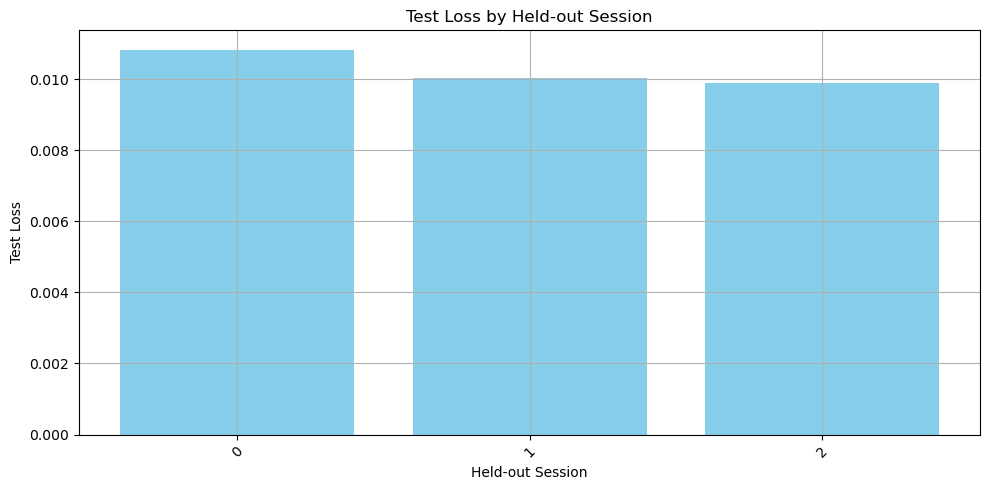

In [13]:
from viz import plot_cv_test_loss_bar
plot_cv_test_loss_bar(cv_results, SPLIT_STRATEGY, savepath=os.path.join(new_dir_path, 'cv_test_loss_bar.png'))




## Correlation plots of predicted vs. ground-truth snippets

In [14]:
# Compute z-score correlations for CV results
from viz import compute_cv_zscore_correlations

cv_results, overall_zscore_corr = compute_cv_zscore_correlations(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    good_pairs=good_pairs,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    stim_delay=STIM_DELAY,
    window_size=50,
    save_dir=os.path.join(new_dir_path, 'zscore_corr_cv'),
    save_plots=True,  # Set to True to save individual plots
)

# Update CV summary with z-score correlations
cv_summary['fold_results'] = [{
    k: v for k, v in r.items() 
    if k not in ['history', 'test_outputs', 'zscore_correlations']
} for r in cv_results]
cv_summary['overall_zscore_corr'] = overall_zscore_corr
cv_summary['fold_zscore_corrs'] = [r.get('mean_zscore_corr', np.nan) for r in cv_results]

# Save updated summary
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"Updated CV summary with z-score correlations saved to {cv_summary_path}")

2026-01-15 17:14:38,107 INFO: Fold 1 | Holdout=0 | Mean Z-Corr=0.5475 (n=208)
2026-01-15 17:14:49,873 INFO: Fold 2 | Holdout=1 | Mean Z-Corr=0.5431 (n=208)
2026-01-15 17:15:01,503 INFO: Fold 3 | Holdout=2 | Mean Z-Corr=0.4962 (n=208)
2026-01-15 17:15:01,504 INFO: Overall Mean Z-Score Correlation: 0.5290 ± 0.3094 (n=624)

Z-SCORE CORRELATION RESULTS (session strategy)
  Fold  1 | Holdout=   0 | Z-Corr=0.5475
  Fold  2 | Holdout=   1 | Z-Corr=0.5431
  Fold  3 | Holdout=   2 | Z-Corr=0.4962
----------------------------------------------------------------------
  OVERALL Mean Z-Score Correlation: 0.5290 ± 0.3094
2026-01-15 17:15:01,506 INFO: Updated CV summary with z-score correlations saved to rnn_training/20260115_170523/cv_summary.json



80th percentile thresholds for target neurons:
  ROI 21: 0.0611 df/F
  ROI 22: 0.0731 df/F
  ROI 23: 0.0665 df/F
  ROI 26: 0.1150 df/F
  ROI 27: 0.0763 df/F
  ROI 31: 0.0715 df/F
2026-01-15 17:15:46,303 INFO: Computed 80th percentile thresholds for 110 ROIs
2026-01-15 17:15:46,304 INFO: Evaluating 6 ROIs: [21, 22, 23, 26, 27, 31]
2026-01-15 17:15:46,304 INFO: 
2026-01-15 17:15:46,305 INFO: FOLD 1: Holdout=0
2026-01-15 17:15:46,305 INFO: ============================================================
2026-01-15 17:15:50,369 INFO: Fold 1 TEST:  Prec=0.6677, Recall=0.7439, Acc=0.7312, F1=0.7038
2026-01-15 17:15:50,369 INFO: Fold 1 TRAIN: Prec=0.7993, Recall=0.8350, Acc=0.8387, F1=0.8168
2026-01-15 17:15:50,370 INFO: 
2026-01-15 17:15:50,370 INFO: FOLD 2: Holdout=1
2026-01-15 17:15:50,371 INFO: ============================================================
2026-01-15 17:15:54,294 INFO: Fold 2 TEST:  Prec=0.7824, Recall=0.5871, Acc=0.7323, F1=0.6708
2026-01-15 17:15:54,294 INFO: Fold 2 TRAIN: P

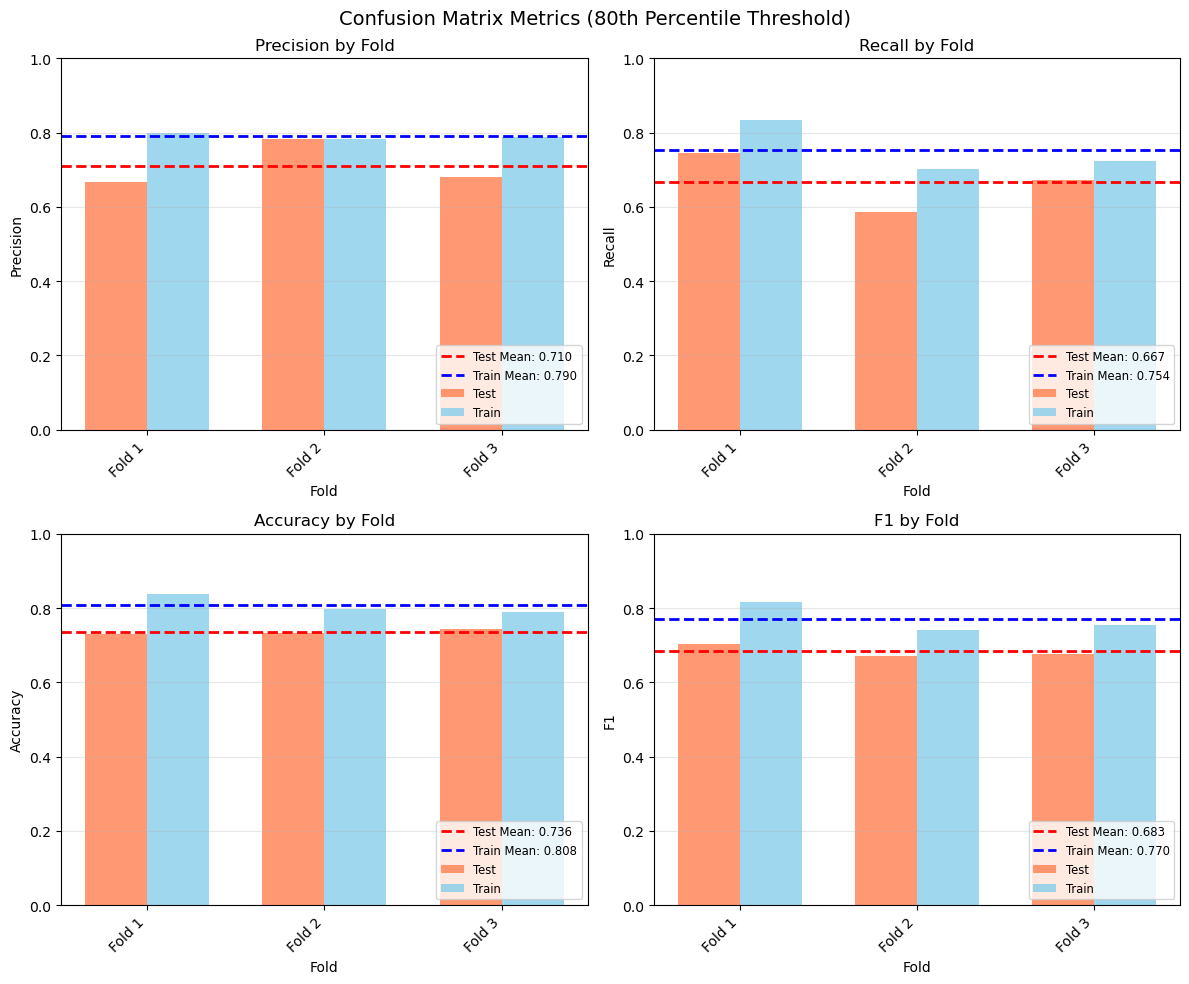

2026-01-15 17:15:58,582 INFO: Updated CV summary with confusion metrics saved to rnn_training/20260115_170523/cv_summary.json


In [15]:
# Compute confusion matrix metrics for CV results
from viz import compute_cv_confusion_metrics, plot_cv_confusion_summary, compute_roi_percentiles

# Set percentile threshold (e.g., 80th percentile means activity above this value is "active")
THRESHOLD_PERCENTILE = 80

# First, compute the thresholds to see what values they correspond to
roi_thresholds = compute_roi_percentiles(dfof, percentile=THRESHOLD_PERCENTILE, filter_neurons=FILTER_NEURONS)
print(f"\n{THRESHOLD_PERCENTILE}th percentile thresholds for target neurons:")
for roi in sorted(TARGET_NEURONS):
    if roi in roi_thresholds:
        print(f"  ROI {roi}: {roi_thresholds[roi]:.4f} df/F")

# Compute confusion metrics
cv_results, confusion_summary = compute_cv_confusion_metrics(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    good_pairs=good_pairs,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    percentile=THRESHOLD_PERCENTILE,
    save_dir=os.path.join(new_dir_path, 'confusion_metrics'),
)

# Plot confusion metrics summary
plot_cv_confusion_summary(
    cv_results=cv_results,
    summary=confusion_summary,
    save_path=os.path.join(new_dir_path, f'confusion_summary_p{THRESHOLD_PERCENTILE}.png'),
)

# Update CV summary with confusion metrics
cv_summary['confusion_summary'] = {
    'percentile': THRESHOLD_PERCENTILE,
    'test_precision': confusion_summary['test']['mean_precision'],
    'test_recall': confusion_summary['test']['mean_recall'],
    'test_accuracy': confusion_summary['test']['mean_accuracy'],
    'test_f1': confusion_summary['test']['mean_f1'],
    'train_precision': confusion_summary['train']['mean_precision'],
    'train_recall': confusion_summary['train']['mean_recall'],
    'train_accuracy': confusion_summary['train']['mean_accuracy'],
    'train_f1': confusion_summary['train']['mean_f1'],
}

# Save updated summary
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"Updated CV summary with confusion metrics saved to {cv_summary_path}")

Plotting CV raster for Config 3, ROI 26
Using 80th percentile threshold: 0.1150
2026-01-15 17:16:02,593 INFO: Saved CV raster to rnn_training/20260115_170523/rasters_cv/raster_cv_c3_roi26.png


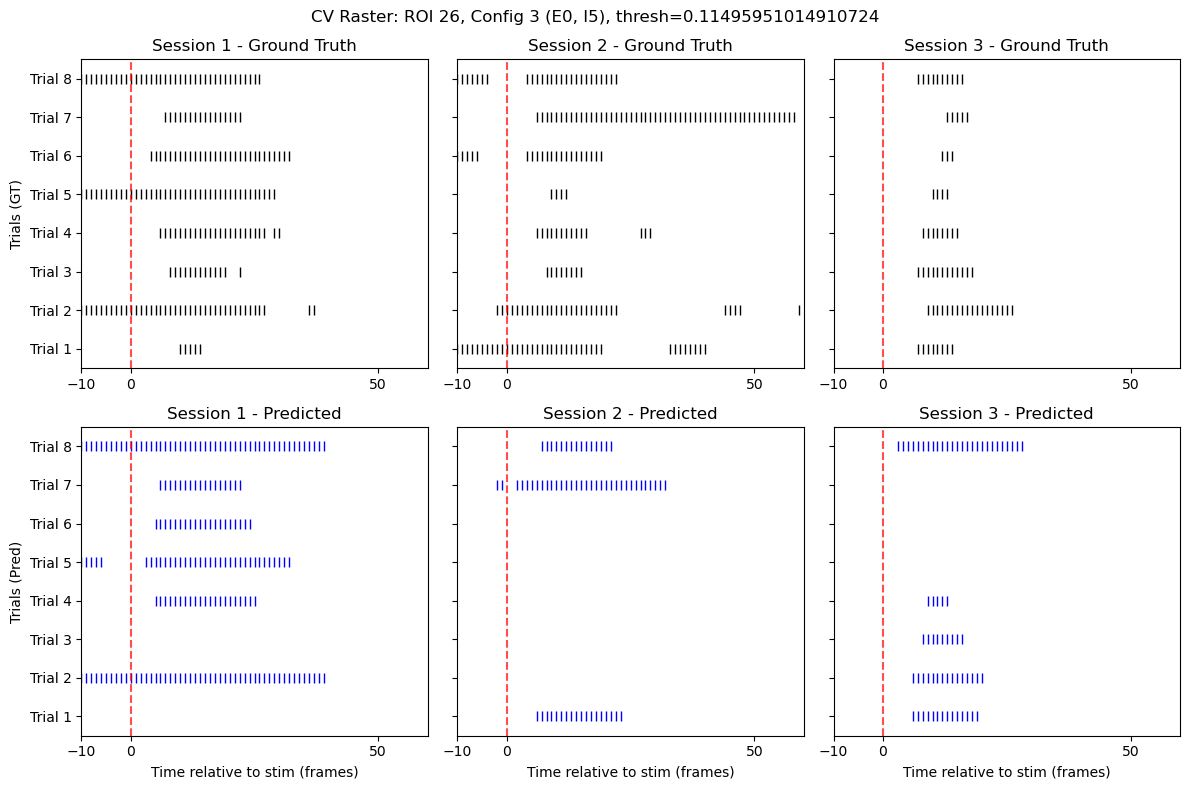

In [16]:
# Plot CV raster for a specific ROI and config
from viz import plot_stim_raster_cv

# Choose a (config, roi) pair from good_pairs to visualize
raster_config, raster_roi = good_pairs[0]  # e.g., (3, 26)

# Use the percentile threshold computed above
raster_threshold = roi_thresholds[raster_roi]

print(f"Plotting CV raster for Config {raster_config}, ROI {raster_roi}")
print(f"Using {THRESHOLD_PERCENTILE}th percentile threshold: {raster_threshold:.4f}")

os.makedirs(os.path.join(new_dir_path, 'rasters_cv'), exist_ok=True)

fig = plot_stim_raster_cv(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    neuron=raster_roi,
    config=raster_config,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    threshold=raster_threshold,
    pre_stim_frames=10,
    post_stim_frames=60,
    sessions=[0, 1, 2],
    save_path=os.path.join(new_dir_path, 'rasters_cv', f'raster_cv_c{raster_config}_roi{raster_roi}.png'),
)
plt.show()

## PSTHs like Yuxuans

In [17]:
from viz import plot_psth_from_cv_results


# Run the CV-based PSTH plotting
import pandas as pd
neurons_by_config = {}
for pair in good_pairs:
    if neurons_by_config.get(str(pair[0])) is None:
        neurons_by_config[str(pair[0])] = [pair[1]]
    else:
        neurons_by_config[str(pair[0])].append(pair[1])
default_neurons = TARGET_NEURONS  # Use all target neurons if no config-specific set



# Only plot neurons that are in TARGET_NEURONS (since model only predicts those)
# neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS]

plot_psth_from_cv_results(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    configs_to_plot=configs_to_plot if 'configs_to_plot' in dir() else list(range(1, 32)),
    neurons_by_config=neurons_by_config,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    stim_delay=STIM_DELAY,
    post_stim_frames=50,
    subplot_size=2.5,
    show_ground_truth=True,
    line_alpha=0.9,
    pred_lw=1.2,
    gt_lw=2.0,
    n_sessions=3,
    save_dir=os.path.join(new_dir_path, 'psths_cv'),
)



2026-01-15 17:16:04,611 INFO: CV split strategy: session
2026-01-15 17:16:04,612 INFO: Holdout elements: [0, 1, 2]
2026-01-15 17:16:04,613 INFO: Config 1: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-15 17:16:08,393 INFO: Saved CV PSTH: rnn_training/20260115_170523/psths_cv/config_1_cv.png
2026-01-15 17:16:08,394 INFO: Config 2: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-15 17:16:11,093 INFO: Saved CV PSTH: rnn_training/20260115_170523/psths_cv/config_2_cv.png
2026-01-15 17:16:11,094 INFO: Config 3: 24 snippets, neurons: [26, 22]
2026-01-15 17:16:11,971 INFO: Saved CV PSTH: rnn_training/20260115_170523/psths_cv/config_3_cv.png
2026-01-15 17:16:11,972 INFO: Config 4: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-15 17:16:16,108 INFO: Saved CV PSTH: rnn_training/20260115_170523/psths_cv/config_4_cv.png
2026-01-15 17:16:16,111 INFO: Config 5: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-15 17:16:19,264 INFO: Saved CV PSTH: rnn_training/20260115_170

## Loss over Epochs Plot

Plotting losses for Fold 1 (holdout=0)


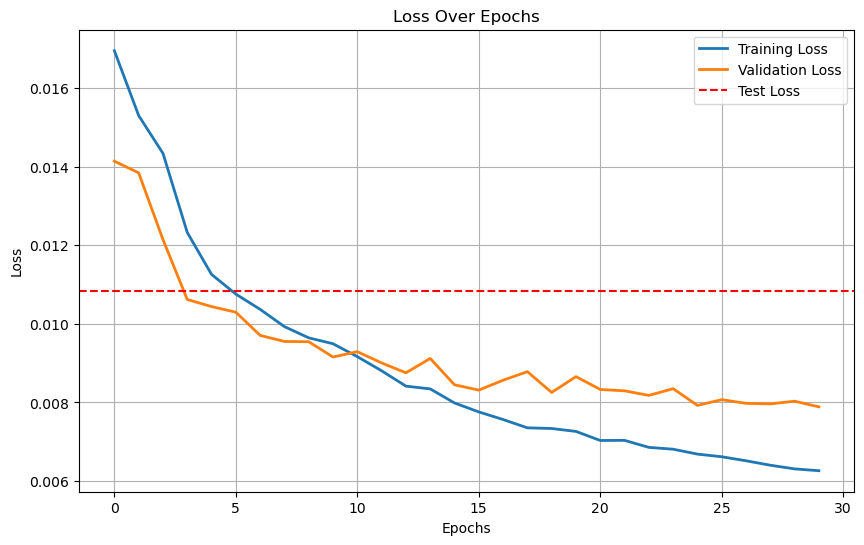

Plotting losses for Fold 2 (holdout=1)


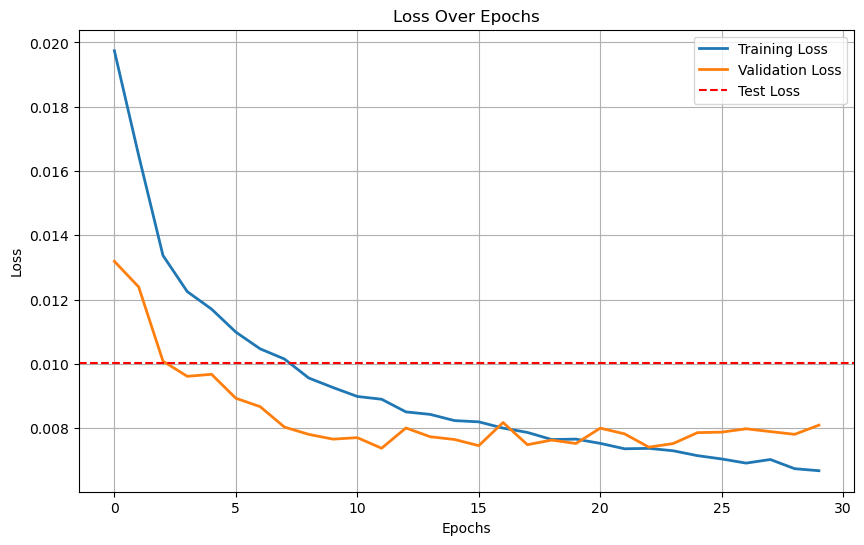

Plotting losses for Fold 3 (holdout=2)


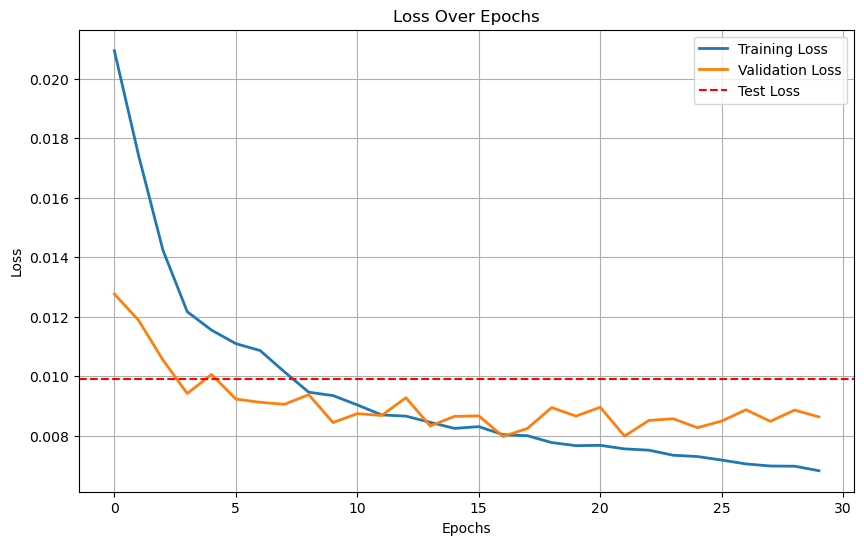


All CV loss plots saved to: rnn_training/20260115_170523/cv_losses


In [18]:
# Plot losses for each fold in cross-validation
from viz import plot_losses

# Create directory for CV loss plots
cv_losses_dir = os.path.join(new_dir_path, 'cv_losses')
os.makedirs(cv_losses_dir, exist_ok=True)

for r in cv_results:
    fold_idx = r['fold']
    holdout_elem = r['holdout_element']
    fold_history = r.get('history', None)
    fold_test_loss = r.get('test_loss', None)
    
    if fold_history is None:
        logging.warning(f"Fold {fold_idx}: No history found, skipping loss plot")
        continue
    
    # Create fold-specific save path
    fold_savepath = os.path.join(cv_losses_dir, f'fold_{fold_idx}_holdout_{holdout_elem}')
    os.makedirs(fold_savepath, exist_ok=True)
    
    print(f"Plotting losses for Fold {fold_idx} (holdout={holdout_elem})")
    plot_losses(fold_history, fold_test_loss, savepath=fold_savepath)

print(f"\nAll CV loss plots saved to: {cv_losses_dir}")

NameError: name 'HOLDOUT_TRIALS' is not defined

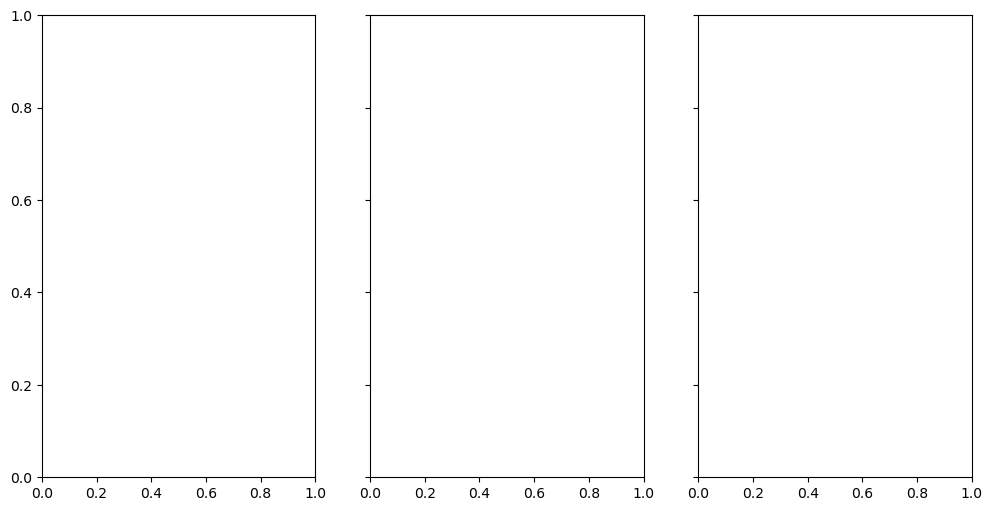

In [19]:
from viz import plot_stim_raster
# Example usage:
# plot_stim_raster(neuron=31, config=27, threshold=0.1)
if not os.path.exists(os.path.join(new_dir_path, "rasters")):
    os.makedirs(os.path.join(new_dir_path, "rasters"))
plot_stim_raster(trials_df, dfof, neuron=31, config=27, threshold=0.25, save_path=os.path.join(new_dir_path, "rasters", "n31_c28_t0.1.png"))

Generating: Config 3, Neuron 26, Threshold 0.1


NameError: name 'HOLDOUT_TRIALS' is not defined

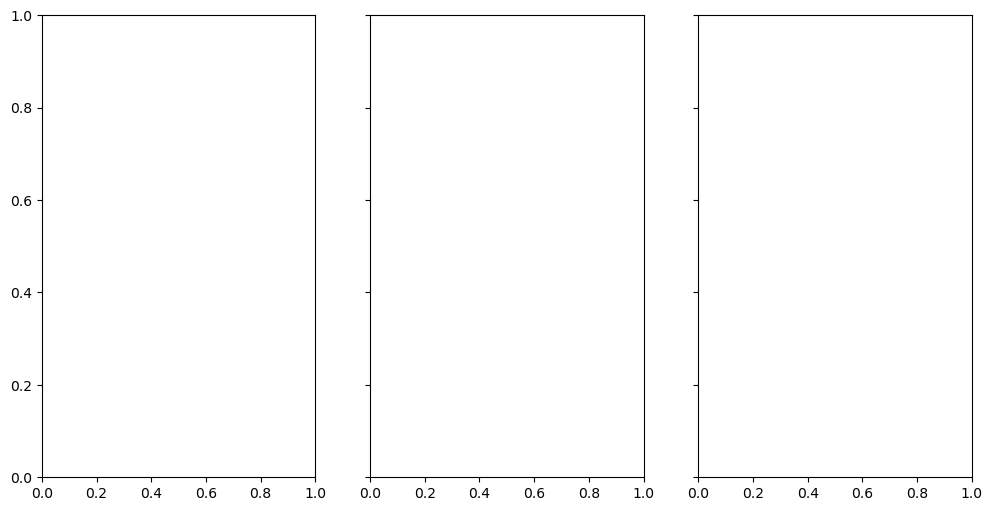

In [ ]:
# # Generate rasters for all good_pairs at multiple thresholds
# # good_pairs format: (config, neuron)
# thresholds = [0.1, 0.2, 0.3]

# # Create rasters directory
# rasters_dir = os.path.join(new_dir_path, "rasters")
# os.makedirs(rasters_dir, exist_ok=True)

# for config, neuron in good_pairs:
#     for thresh in thresholds:
#         save_name = f"raster_c{config}_n{neuron}_t{thresh}.png"
#         save_path = os.path.join(rasters_dir, save_name)
#         print(f"Generating: Config {config}, Neuron {neuron}, Threshold {thresh}")
#         plot_stim_raster(trials_df=trials_df, dfof=dfof, neuron=neuron, config=config, threshold=thresh, save_path=save_path)
#         plt.close()

# print(f"\nSaved {len(good_pairs) * len(thresholds)} raster plots to {rasters_dir}")

Config 1: Electrode 0, Current 3
Config 2: Electrode 0, Current 4
Config 3: Electrode 0, Current 5
Config 4: Electrode 1, Current 3
Config 5: Electrode 1, Current 4
Config 6: Electrode 1, Current 5
Config 7: Electrode 2, Current 3
Config 8: Electrode 2, Current 4
Config 9: Electrode 2, Current 5
Config 10: Electrode 3, Current 3
Config 11: Electrode 3, Current 4
Config 12: Electrode 3, Current 5
Config 13: Electrode 4, Current 3
Config 14: Electrode 4, Current 4
Config 15: Electrode 4, Current 5
Config 16: Electrode 5, Current 3
Config 17: Electrode 5, Current 4
Config 18: Electrode 5, Current 5
Config 19: Electrode 6, Current 3
Config 20: Electrode 6, Current 4
Config 21: Electrode 6, Current 5
Config 22: Electrode 7, Current 3
Config 23: Electrode 7, Current 4
Config 24: Electrode 7, Current 5
Config 25: Electrode 8, Current 3
Config 26: Electrode 8, Current 4
Config 27: Electrode 8, Current 5
Config 28: Electrode 9, Current 3
Config 29: Electrode 9, Current 4
Config 30: Electrode 9,

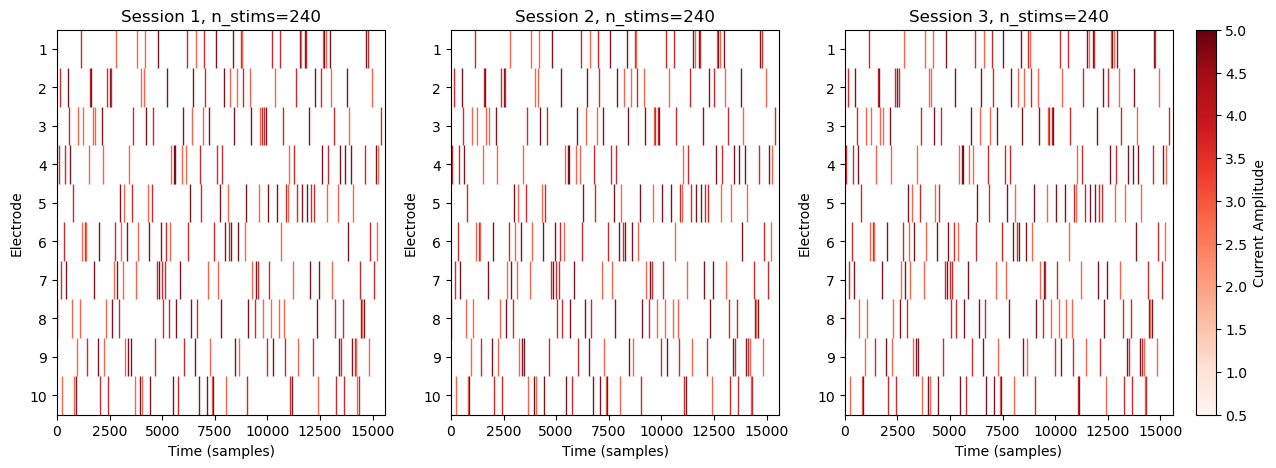

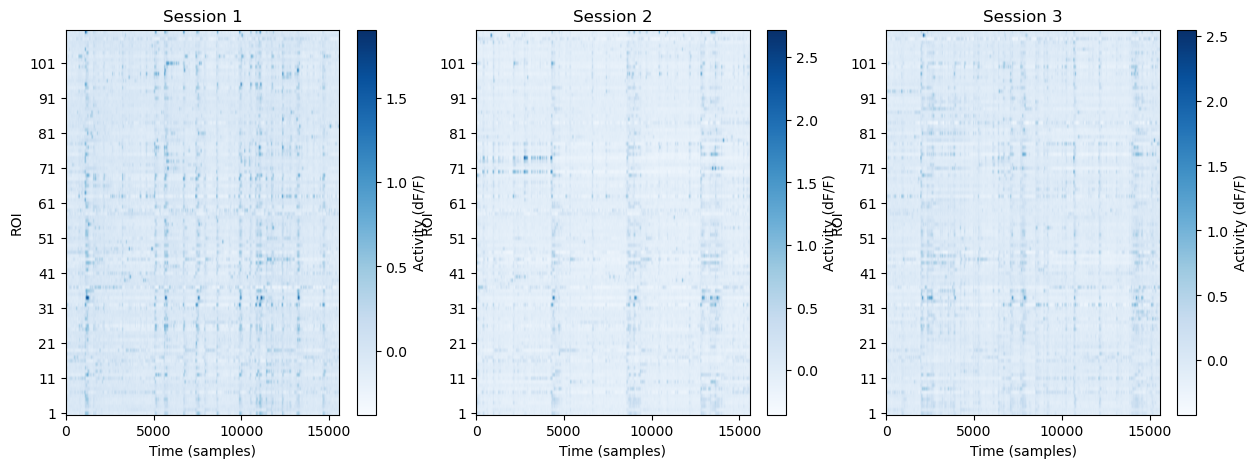

In [22]:
from viz import plot_stim_ticks, plot_activity_per_session
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')




plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')